## TOC:
* [EDA](#Loading)
* [Binary Feature selection](#Selecting-binary)
* [Continous Feature selection](#Selecting-continous)
* [Categorical Feature selection](#Selecting-categorical)
* [Cross-Validation dataset](#cross-validation)
* [Hyperparameter tuning](#ElasticNet)
* [Summary](#Summary)

*Week 3 Assignment*

**EDA and Training Linear Models**
***Ryan Amundson***

In this notebook, we are starting some explority data anaylsis along with training one linear model, a ridge regressor. We are also then training a random forest regressor and finally, trying a Catboost regressor, which is a boosting algorithm that can also handle categorical data. For the catebost regressor, I'm attempting to search through some of the hyperparemters with a grid search. Along with the log transformation, I've decided to use only the top 10 varibles in 3 seperate categries in the training set to eliminate some features that might not be adding too much value. To deterine those I've fitted descison trees to the data and looked at the feature importance. I also decided to stick with one-hot encoding, using pands get_dummies method, because without knowing the meaning of the categories, it is impossible to determine if they are ordinal or not. 

In the EDA, looking at the loss column, it seems like it is highly right skewed, so it seems like doing a log transformation to normalize the data would be a good idea, so I'm also doing a transform on the target varible in training and then inverting that transformation. 

For training a model and fitting, I'm doning a grid search for a set of prameters for each model to try to optimize the model fit for each model. For the final kaggle submission, I will use the average of all three tuned models and see how the results turn out. 


In [ ]:
# Imports
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.features import FeatureImportances
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.features import Rank1D, Rank2D
from sklearn import metrics 
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

%matplotlib inline

## EDA <a class="anchor" id="Loading"></a>

In [2]:
allstateDf = pd.read_csv('allstate-claims-severity/train.csv')

print("There are {} missing rows in the data".format(sum(allstateDf.isna().sum())))

allstateCleanDf = allstateDf.dropna()


# It looks like there are quite a few categories without much description here, so I'll 
# break them up in to binary and then multiclas categories. There are also 14 continous variables and 
# an id, along with the loss variable. 

categoryCols = [col for col in list(allstateCleanDf.columns) if col.startswith("cat")]
continousCols = [col for col in list(allstateCleanDf.columns) if col.startswith("cont")]
binaryCats = [col for col in categoryCols if len(allstateCleanDf[col].unique()) == 2]
multivalueCats = set(categoryCols) - set(binaryCats)

There are 0 missing rows in the data


In [3]:
allstateCleanDf[binaryCats].describe()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72
count,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,...,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,A,A,A,A,A,A,A,A,A,A,...,A,A,A,A,A,A,A,A,A,A
freq,141550,106721,177993,128395,123737,131693,183744,177274,113122,160213,...,188239,188271,186056,179982,187626,188176,188011,188295,178646,118322


In [4]:
allstateCleanDf[multivalueCats].describe()

,cat78,cat103,cat94,cat86,cat74,cat114,cat92,cat116,cat107,cat93,...,cat100,cat112,cat82,cat84,cat111,cat79,cat109,cat110,cat83,cat91
count,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,...,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318
unique,4,13,7,4,3,19,7,326,20,5,...,15,51,4,4,16,4,84,131,4,8
top,B,A,D,B,A,A,A,HK,F,D,...,F,E,B,C,A,B,BI,CL,B,A
freq,186526,123737,121642,103852,184731,131693,124689,21061,47310,150237,...,42970,25148,147536,154939,128395,152929,152918,25305,141534,111028


In [5]:
allstateCleanDf[continousCols].describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848


In [6]:
allstateCleanDf["loss"].describe()

count    188318.000000
mean       3037.337686
std        2904.086186
min           0.670000
25%        1204.460000
50%        2115.570000
75%        3864.045000
max      121012.250000
Name: loss, dtype: float64

Percent of small claims (less then 5000): %83.59


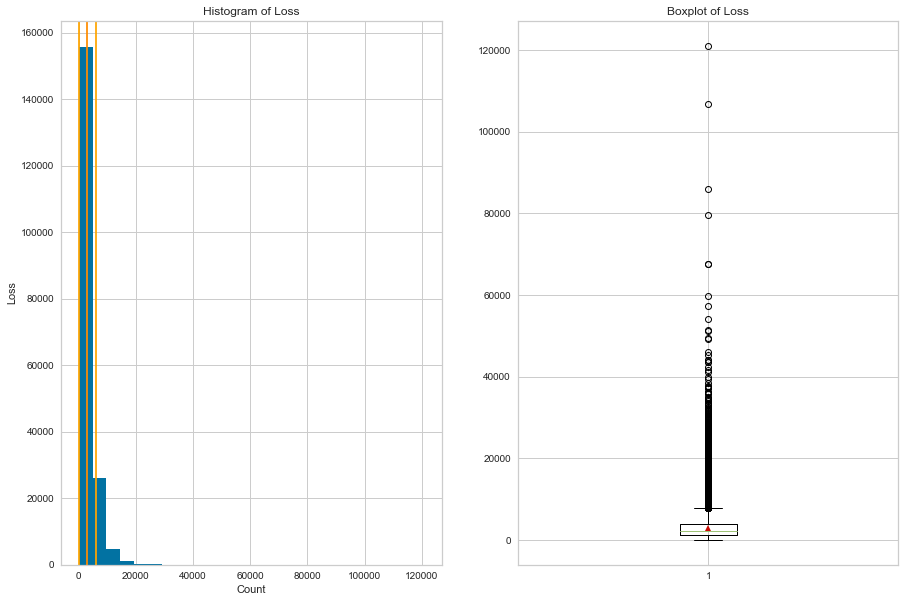

In [7]:
# Lets look at the loss metric, as that is what is meant to be predicted

fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

lossMean = allstateCleanDf['loss'].mean()
lossStd = allstateCleanDf['loss'].std()

ax1.hist(allstateCleanDf['loss'], bins=25)
ax1.axvline(lossMean, color='darkorange')
ax1.axvline(lossMean + lossStd, color='orange')
ax1.axvline(lossMean - lossStd, color='orange')
ax1.set_xlabel("Count")
ax1.set_ylabel("Loss")
ax1.title.set_text("Histogram of Loss")

ax2.boxplot(allstateCleanDf['loss'], showmeans=True)
ax2.title.set_text("Boxplot of Loss")

print("Percent of small claims (less then 5000): %{:.2f}".format(len(allstateCleanDf[allstateCleanDf['loss'] < 5000]) / float(len(allstateCleanDf['loss'])) * 100 ))


It looks like most of the claims are smaller which makes sense, with around %84 being under 5000 or or less. The mean claim 3037, and there is quite a bit of right skew as the loss gets larger.

## Binary Features <a class="anchor" id="Selecting-binary"></a>

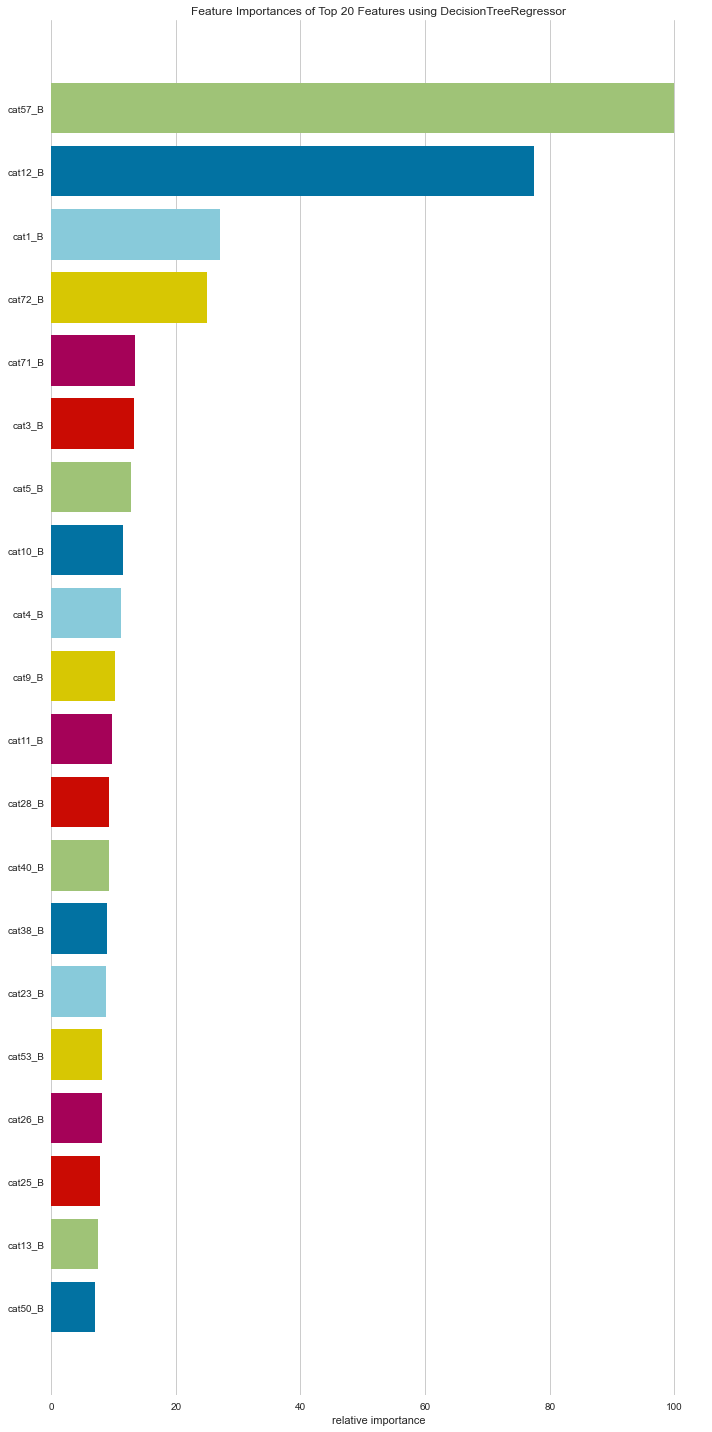

In [9]:
# Here we are training a descision tree regressor on the binary classes and can use yellowbrick to rank thier importance
# This should give us an idea of which categories might be more important to determining loss. 
# We are using get dummies to encode the categories into a binary varible for analysis

clf = DecisionTreeRegressor()
viz = FeatureImportances(clf, topn=20)

visDf = pd.get_dummies(allstateCleanDf[binaryCats], columns=binaryCats, drop_first=True)

fig, ax = plt.subplots(1, figsize=(10, 20))
sns.despine(left=True, bottom=True)

viz.fit(visDf, allstateCleanDf.loss)
viz.show()


top20binary = [f.split("_")[0] for f in list(viz.features_[-20:][::-1])]



In [10]:
len(visDf.columns)

72

It looks like the top 10 most important for determining loss for the decsion tree is "cat57", "cat12", "cat1", "cat72", "cat71", "cat3", "cat5", "cat10", "cat4" and "cat38" so let's take a look at those first.

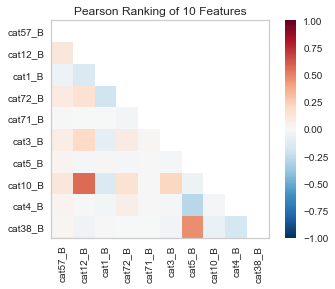

<AxesSubplot:title={'center':'Pearson Ranking of 10 Features'}>

In [11]:
topTenCategories = ["cat57", "cat12", "cat1", "cat72", "cat71", "cat3", "cat5", "cat10", "cat4", "cat38"]

vis = Rank2D()

visDf = allstateCleanDf[topTenCategories]

visDf = pd.get_dummies(visDf, columns=topTenCategories, drop_first=True)
visDf = visDf.dropna()


yVis = allstateCleanDf.loss
vis.fit(visDf, yVis)
vis.transform(visDf)
vis.show()

## Continous Features <a class="anchor" id="Selecting-continous"></a>

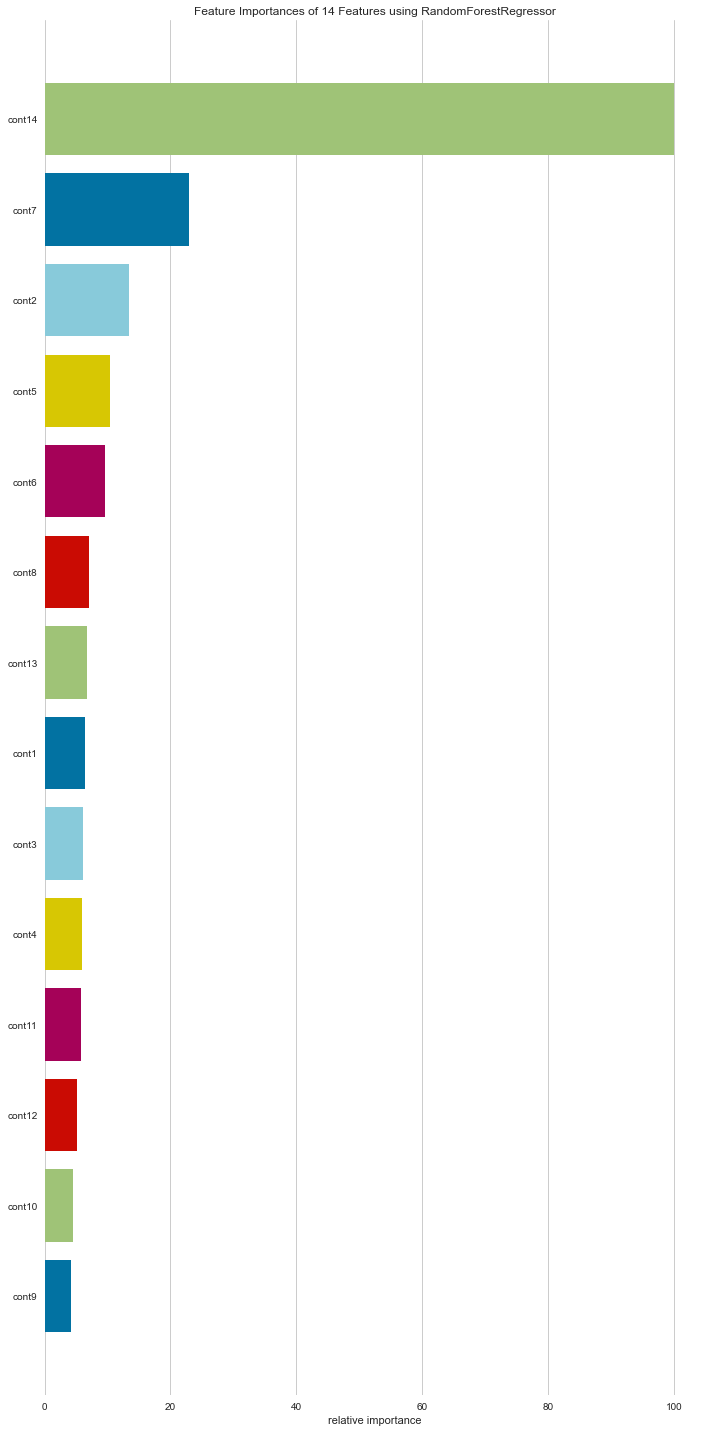

In [12]:
# Here we are training a random forest regressor on the continous classes and can use yellowbrick to rank thier importance
# This should give us an idea of which of the continous categories might be more important to determining loss. 

clf = RandomForestRegressor()
viz = FeatureImportances(clf)

visDf = allstateCleanDf[continousCols].copy()

fig, ax = plt.subplots(1, figsize=(10, 20))
sns.despine(left=True, bottom=True)

viz.fit(visDf, allstateCleanDf.loss)
viz.show()

top10Cont = list(viz.features_[-10:][::-1])


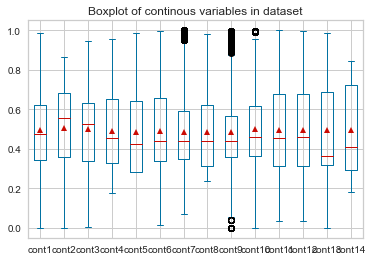

In [13]:
# Lets do a boxblot of all the continous varibles in the dataset to get an idea of what they look like
ax = allstateCleanDf[continousCols].plot(kind='box', title='Boxplot of continous variables in dataset', showmeans=True)

plt.show()

For the continous varibles, it looks like they have all been normalized from 0-1. cont9 cantains a number of outliers at the upper end of the scale and some at the bottom. Cont7 and cont10 are the only other categroies that conatin obvious outliers. It looks like cont13 is very skewed, along with cont14.

## Categorical Features <a class="anchor" id="Selecting-categorical"></a>

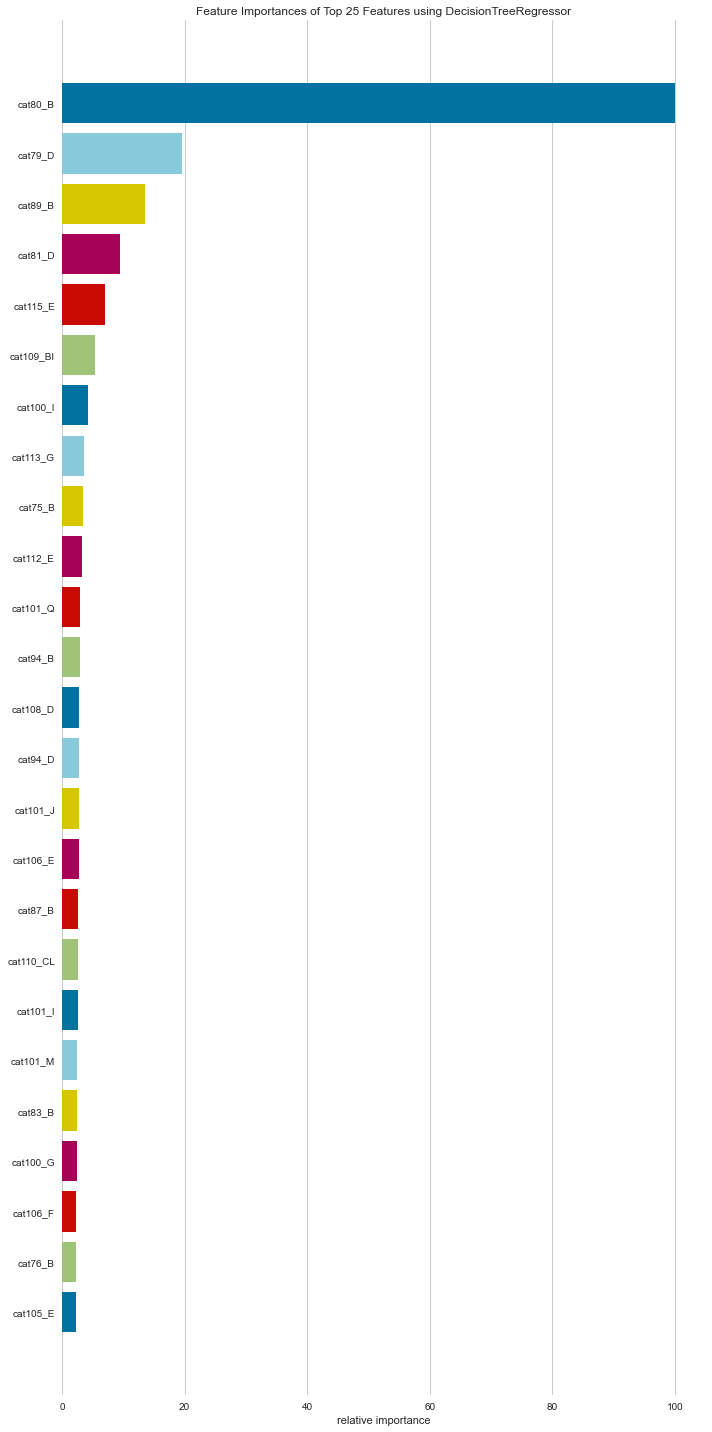

In [14]:
# Now lets try training a descision tree regressor on the multiclass classes and can use yellowbrick to rank thier importance
# This should give us an idea of which of those categories might be more important to determining loss. 
# We are using get dummies to encode the categories

clf = DecisionTreeRegressor()
viz = FeatureImportances(clf, topn=25)

visDf = pd.get_dummies(allstateCleanDf[multivalueCats], columns=multivalueCats, drop_first=True)

fig, ax = plt.subplots(1, figsize=(10, 20))
sns.despine(left=True, bottom=True)

viz.fit(visDf, allstateCleanDf.loss)
viz.show()

top25OneHotCat = [f.split("_")[0] for f in list(viz.features_[-25:][::-1])]


<AxesSubplot:>

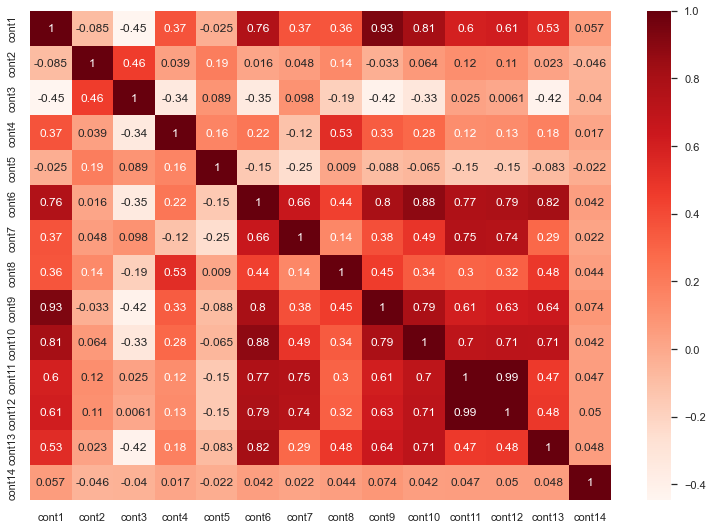

In [74]:
# Lets also do a correlation matrix of the continous variblss to get an idea of how correlated they are
corrMat = allstateCleanDf[continousCols].corr()

fig, ax = plt.subplots(figsize=(13, 9))
sns.set(font_scale = 1)
sns.heatmap(corrMat, annot=True, cmap="Reds")

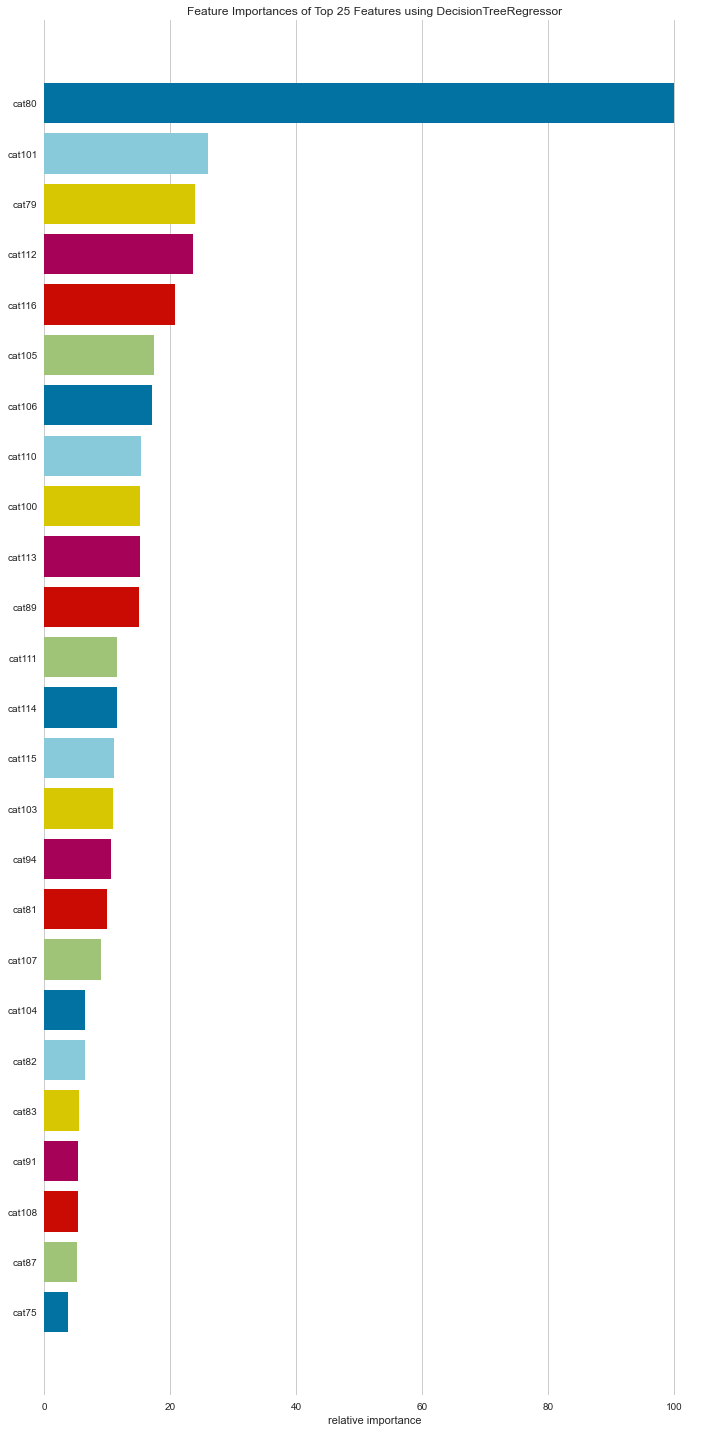

In [15]:
# Now lets try training a descision tree regressor on the multiclass classes but using label endcoding this time
# and can use yellowbrick to rank their importance
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

clf = DecisionTreeRegressor()
viz = FeatureImportances(clf, topn=25)

visDf = pd.DataFrame({col: allstateCleanDf[col].astype('category').cat.codes for col in multivalueCats})
#visDf = pd.get_dummies(allstateCleanDf[multivalueCats], columns=multivalueCats, drop_first=True)

fig, ax = plt.subplots(1, figsize=(10, 20))
sns.despine(left=True, bottom=True)

viz.fit(visDf, allstateCleanDf.loss)
viz.show()

top25LabelMulti = list(viz.features_[-25:][::-1])

In [16]:
# Check for overlap in the two top ten for multi catsgories, and use those
topCats = set(top25OneHotCat).union(set(top25LabelMulti)) 
topCats

{'cat100',
 'cat101',
 'cat103',
 'cat104',
 'cat105',
 'cat106',
 'cat107',
 'cat108',
 'cat109',
 'cat110',
 'cat111',
 'cat112',
 'cat113',
 'cat114',
 'cat115',
 'cat116',
 'cat75',
 'cat76',
 'cat79',
 'cat80',
 'cat81',
 'cat82',
 'cat83',
 'cat87',
 'cat89',
 'cat91',
 'cat94'}

In [17]:
visDf.head()

,cat78,cat103,cat94,cat86,cat74,cat114,cat92,cat116,cat107,cat93,...,cat100,cat112,cat82,cat84,cat111,cat79,cat109,cat110,cat83,cat91
0,1,0,1,3,0,0,0,269,9,3,...,1,19,1,2,2,1,45,28,3,0
1,1,0,3,3,0,0,0,85,10,3,...,11,22,0,2,0,1,33,65,1,0
2,1,1,3,1,0,0,0,153,5,3,...,11,28,1,2,0,1,2,85,3,0
3,1,0,3,3,0,0,0,79,10,3,...,8,39,3,2,2,1,33,67,1,0
4,1,0,1,1,0,0,5,55,6,3,...,5,50,1,2,2,3,66,50,1,1


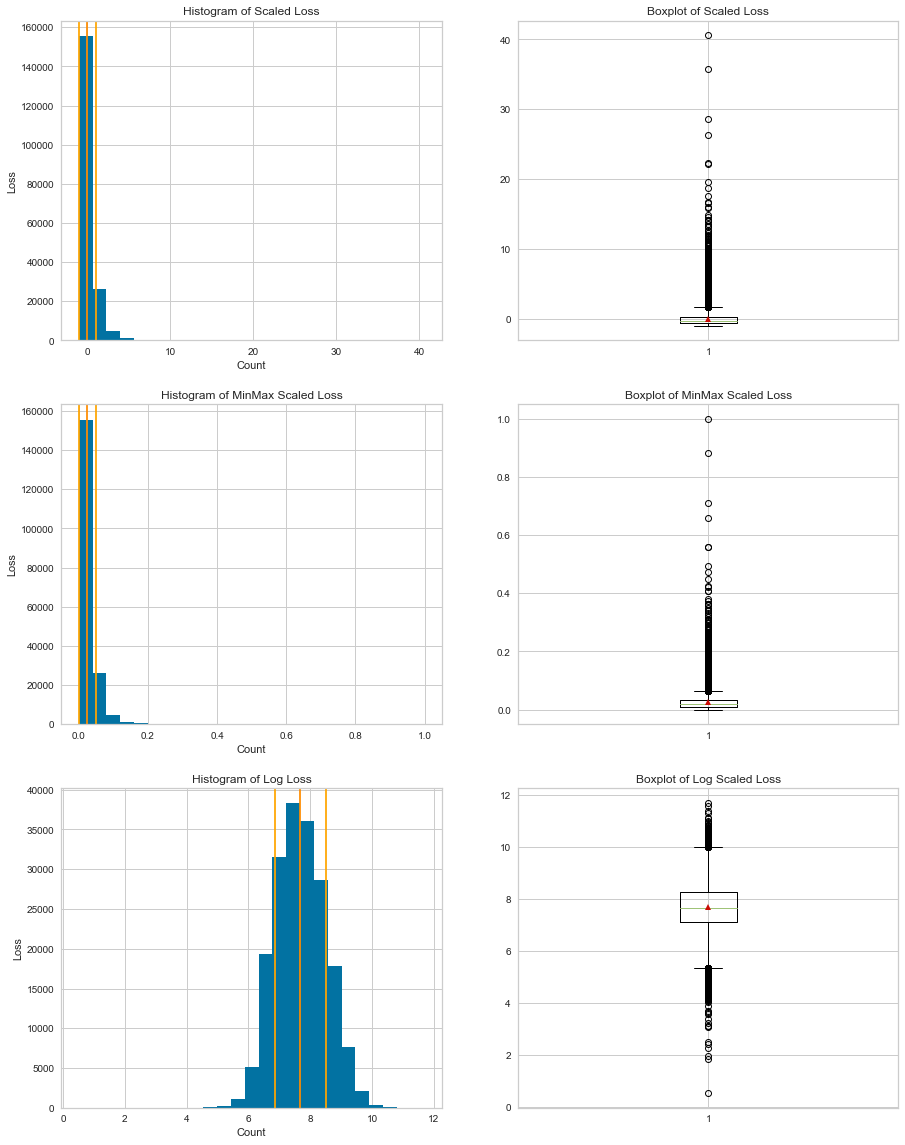

In [18]:
# Now let's scale the loss varible and look at again, the histgram and boxplot should look the same, but the scaling
# is different. Becaouse of the massive right skew, let's also apply a log transform to normalize the loss data 
# and view that

scaler = StandardScaler()
mmScaler = MinMaxScaler()


allstateCleanDf['loss_scaled'] = scaler.fit_transform(np.array(allstateCleanDf['loss']).reshape(-1, 1))
allstateCleanDf['loss_min_max_scaled'] = mmScaler.fit_transform(np.array(allstateCleanDf['loss']).reshape(-1, 1))
allstateCleanDf['loss_log'] = np.log1p(allstateCleanDf['loss'])

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,20))

lossMean = allstateCleanDf['loss_scaled'].mean()
lossStd = allstateCleanDf['loss_scaled'].std()

ax1.hist(allstateCleanDf['loss_scaled'], bins=25)
ax1.axvline(lossMean, color='darkorange')
ax1.axvline(lossMean + lossStd, color='orange')
ax1.axvline(lossMean - lossStd, color='orange')
ax1.set_xlabel("Count")
ax1.set_ylabel("Loss")
ax1.title.set_text("Histogram of Scaled Loss")

ax2.boxplot(allstateCleanDf['loss_scaled'], showmeans=True)
ax2.title.set_text("Boxplot of Scaled Loss")


lossMeanMM = allstateCleanDf['loss_min_max_scaled'].mean()
lossStdMM = allstateCleanDf['loss_min_max_scaled'].std()

ax3.hist(allstateCleanDf['loss_min_max_scaled'], bins=25)
ax3.axvline(lossMeanMM, color='darkorange')
ax3.axvline(lossMeanMM + lossStdMM, color='orange')
ax3.axvline(lossMeanMM - lossStdMM, color='orange')
ax3.set_xlabel("Count")
ax3.set_ylabel("Loss")
ax3.title.set_text("Histogram of MinMax Scaled Loss")

ax4.boxplot(allstateCleanDf['loss_min_max_scaled'], showmeans=True)
ax4.title.set_text("Boxplot of MinMax Scaled Loss")


lossMeanLog = allstateCleanDf['loss_log'].mean()
lossStdLog = allstateCleanDf['loss_log'].std()

ax5.hist(allstateCleanDf['loss_log'], bins=25)
ax5.axvline(lossMeanLog, color='darkorange')
ax5.axvline(lossMeanLog + lossStdLog, color='orange')
ax5.axvline(lossMeanLog - lossStdLog, color='orange')
ax5.set_xlabel("Count")
ax5.set_ylabel("Loss")
ax5.title.set_text("Histogram of Log Loss")

ax6.boxplot(allstateCleanDf['loss_log'], showmeans=True)
ax6.title.set_text("Boxplot of Log Scaled Loss")

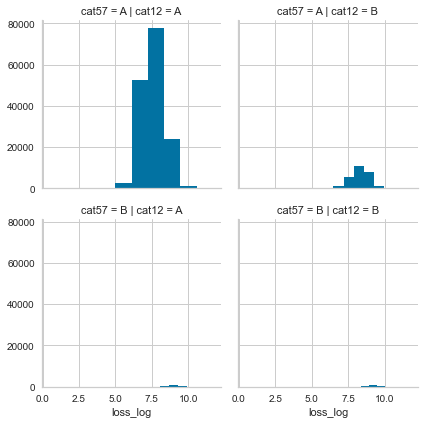

In [19]:
# Let's plot the top two boolean varibles in a facet grid
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(allstateCleanDf, row="cat57", col="cat12")
g.map(plt.hist, "loss_log")
plt.show()

## Cross-validation dataset creation <a class="anchor" id="cross-validation"></a>

In [42]:
# Lets use the top overlapping categories or top 10 binary and then all the continous categories
# and create a test/train set

topFeatures = list(topCats) + top20binary + continousCols

X, X_test, y, y_test = train_test_split(allstateCleanDf[topFeatures].copy(), 
                                        allstateCleanDf['loss'], 
                                        test_size=0.2, 
                                        random_state=42)

X_train_encoded = pd.get_dummies(X, columns=top20binary, drop_first=True)
#X_train_encoded = pd.get_dummies(X_train_encoded, columns=list(topCats))
X_train_encoded[list(topCats)] = X_train_encoded[list(topCats)].astype('category')
X_train_encoded[list(topCats)] = X_train_encoded[list(topCats)].apply(lambda x: x.cat.codes)

X_test_encoded = pd.get_dummies(X_test, columns=top20binary, drop_first=True)
X_test_encoded[list(topCats)] = X_test_encoded[list(topCats)].astype('category')
X_test_encoded[list(topCats)] = X_test_encoded[list(topCats)].apply(lambda x: x.cat.codes)
#X_test_encoded = pd.get_dummies(X_test_encoded, columns=list(topCats))

# Add any missing features in the test set
encoded_cats = X_train_encoded.columns

test_encoded = X_test_encoded.columns

missing = set(encoded_cats) - set(test_encoded)

missing_from_train = set(test_encoded) - set(encoded_cats)

X_test_encoded[list(missing)] = 0

X_train_encoded[list(missing_from_train)] = 0

In [43]:
print("Make sure the columns are the same")

assert(len( X_test_encoded.columns) == len( X_train_encoded.columns))

Make sure the columns are the same


## ElasticNet Tuning <a class="anchor" id="ElasticNet"></a>

Best alpha parameter: {'linear_regression__regressor__alpha': 0.25, 'linear_regression__regressor__l1_ratio': 0.1}
Root Mean Squared Error: 2300.909902964984
Predicted and test have a correlation of: 0.65


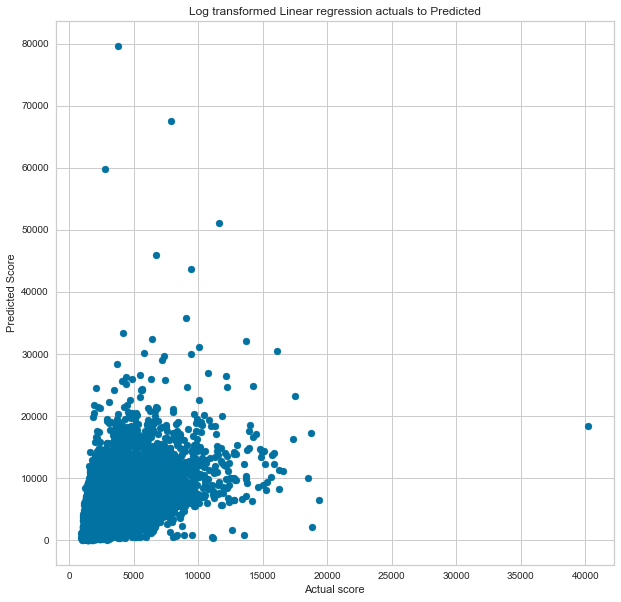

In [44]:
# Becaouse of the massive right skew, lets apply a log transform to normalize the loss data more, and 
# then run a linear model on the data to get a baseline, here we are using elasticnet

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV


# Let's try a series of alphas for paramter tuning
# Along with attempting some parametric pareters
grid = {}
grid['linear_regression__regressor__alpha'] = np.linspace(0.25, 2, num=5)
grid['linear_regression__regressor__l1_ratio'] = np.linspace(0.1, 0.9, num=5)
linear_regression = TransformedTargetRegressor(regressor=ElasticNet(max_iter=2000), func=np.log1p, inverse_func=np.expm1)
pipeline = Pipeline([("scaler", StandardScaler()),
                    ("linear_regression", linear_regression)])
    
gscv = GridSearchCV(
                    pipeline, 
                    grid, 
                    scoring='r2', 
                    cv=3,
                    n_jobs=2)

l_grid_result = gscv.fit(X_train_encoded, y)
l_best_params = l_grid_result.best_params_

print("Best alpha parameter: {}".format(l_best_params))
# prepare the model with target scaling
best_alpha = l_best_params['linear_regression__regressor__alpha']
best_l1 = l_best_params['linear_regression__regressor__l1_ratio']
pipeline = Pipeline([("scaler", StandardScaler()),
                    ("linear_regression", TransformedTargetRegressor(regressor=ElasticNet(alpha=best_alpha, l1_ratio=best_l1, max_iter=2000), func=np.log1p, inverse_func=np.expm1))])


pipeline.fit(X_train_encoded, y)
y_pred = pipeline.predict(X_test_encoded)

fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(111)

rmse1 = np.sqrt(metrics.mean_squared_error(y_pred, y_test))
print ("Root Mean Squared Error: %s" % rmse1)

ax1.scatter(y_pred, y_test)
ax1.set_xlabel("Actual score")
ax1.set_ylabel("Predicted Score")
ax1.title.set_text("Log transformed Linear regression actuals to Predicted")

# Pearson correlation for the predicted values
print("Predicted and test have a correlation of: {:.2f}".format(np.corrcoef(y_pred, y_test)[0][1]))


In [25]:
pipeline.get_params().keys()

np.linspace(0.00001, 0.9, num=7)

array([1.00000000e-05, 1.50008333e-01, 3.00006667e-01, 4.50005000e-01,
       6.00003333e-01, 7.50001667e-01, 9.00000000e-01])

Best parameters: {'regressor__max_depth': 16, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 1500}
Root Mean Squared Error: 2062.027446970329
Predicted and test have a correlation of: 0.73


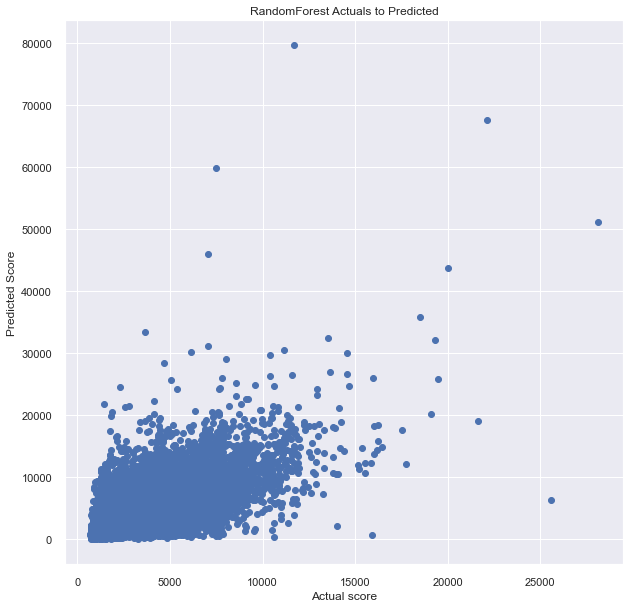

In [75]:
# Let also try a random forest predictor on the data, this time lets use a halving grid parameter search, as 
# other techniques are taking far too long on my machine


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 1500, num = 4)]

grid = {'regressor__n_estimators': n_estimators,
        'regressor__max_depth': [int(x) for x in np.linspace(14, 24, num = 5)],
        'regressor__min_samples_split':  [4, 5, 7],
        'regressor__max_features': ["auto"],
        'regressor__min_samples_leaf': [2, 3]}

# Lets search 21 random variations and get the best
rf_random = GridSearchCV(estimator=TransformedTargetRegressor(regressor=RandomForestRegressor(), func=np.log1p, inverse_func=np.expm1), 
                               param_grid=grid, cv=3, n_jobs=3)

# Fit the random search model
#rf_grid_result = rf_random.fit(X_train_encoded, y)
rf_best_params = {'regressor__max_depth': 16, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 1500}#rf_grid_result.best_params_

print("Best parameters: {}".format(rf_best_params))


# prepare the model with target scaling
rfr_trans = TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=rf_best_params['regressor__n_estimators'],
                                                                      max_depth=rf_best_params['regressor__max_depth'],
                                                                      min_samples_split=rf_best_params['regressor__min_samples_split'],
                                                                      min_samples_leaf=rf_best_params['regressor__min_samples_leaf'],
                                                                      max_features=rf_best_params['regressor__max_features']), 
                                       func=np.log1p, inverse_func=np.expm1)

rfr_trans.fit(X_train_encoded, y)

predictions = rfr_trans.predict(X_test_encoded)

fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(111)

rmse1 = np.sqrt(metrics.mean_squared_error(predictions, y_test))
print ("Root Mean Squared Error: %s" % rmse1)

ax1.scatter(predictions, y_test)
ax1.set_xlabel("Actual score")
ax1.set_ylabel("Predicted Score")
ax1.title.set_text("RandomForest Actuals to Predicted")

# Pearson correlation for the predicted values
print("Predicted and test have a correlation of: {:.2f}".format(np.corrcoef(predictions, y_test)[0][1]))

In [31]:
# Save out out model, so if the computer crashes, I can just reload it
import joblib

filename = 'rfr_trans.sav'
joblib.dump(rfr_trans, filename)


['rfr_trans.sav']

/usr/local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Root Mean Squared Error: 1907.5246987767453
Predicted and test have a correlation of: 0.76


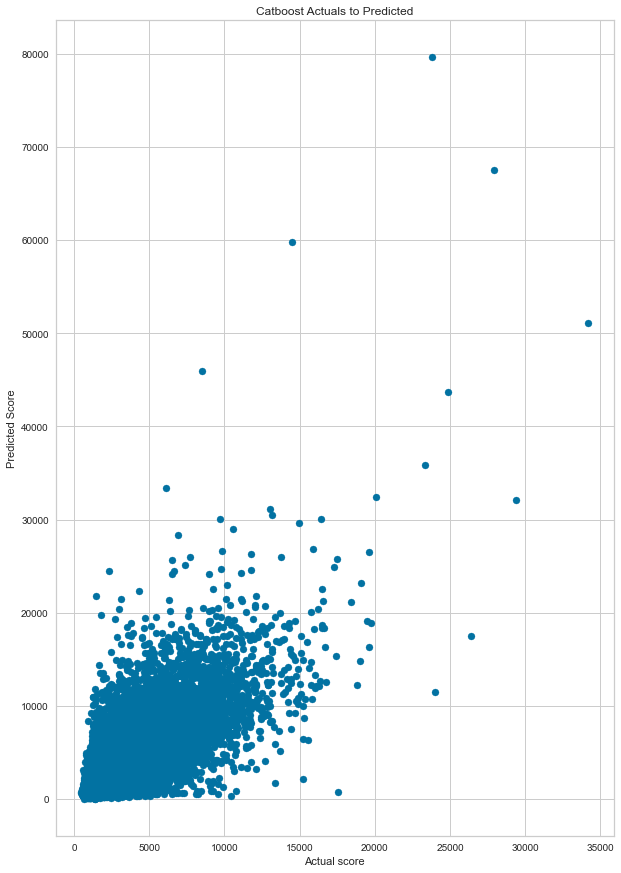

In [50]:
# Now let's try fitting a catboost regressor to the data and do some hyper parameter tuning and see what we can get
# using that regressor. I've narrowed down the regressor with better values on repeated runs, but using lower number of 
# runs and RandomizedSearchCV so my labtop can handle it. 

import catboost as cb
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV


gscat = RandomizedSearchCV (
        estimator=TransformedTargetRegressor(regressor=cb.CatBoostRegressor(cat_features=list(topCats) + top20binary), func=np.log1p, inverse_func=np.expm1),
        #param_grid={
        param_distributions={
            'regressor__depth': [5, 7, 9],
            'regressor__learning_rate' : [0.2, 0.075, 0.1],
            'regressor__l2_leaf_reg': [4, 6, 7],
            'regressor__iterations': [400]

        },
        cv=3, n_iter=5, scoring='r2', verbose=0, n_jobs=3)


c_grid_result = gscat.fit(X, y, logging_level='Silent')
c_best_params = c_grid_result.best_params_

crgr_trans = TransformedTargetRegressor(regressor=cb.CatBoostRegressor(random_state=42, depth=c_best_params["regressor__depth"], 
                            learning_rate=c_best_params["regressor__learning_rate"], l2_leaf_reg=c_best_params["regressor__l2_leaf_reg"], 
                            iterations=c_best_params["regressor__iterations"], cat_features=list(topCats) + top20binary,
                            ),
            func=np.log1p, inverse_func=np.expm1)
crgr_trans.fit(X, y, logging_level='Silent')

y_pred_cat = crgr_trans.predict(X_test)


fig = plt.figure(figsize=(10,15))
ax1 = plt.subplot(111)

rmse1 = np.sqrt(metrics.mean_squared_error(y_pred_cat, y_test))
print ("Root Mean Squared Error: %s" % rmse1)

ax1.scatter(y_pred_cat, y_test)
ax1.set_xlabel("Actual score")
ax1.set_ylabel("Predicted Score")
ax1.title.set_text("Catboost Actuals to Predicted")

# Pearson correlation for the predicted values
print("Predicted and test have a correlation of: {:.2f}".format(np.corrcoef(y_pred_cat, y_test)[0][1]))


In [52]:
# Save out out model, so if the computer crashes, I can just reload it
filename = 'crgr_trans.sav'

joblib.dump(crgr_trans, filename)

print(c_best_params)

{'regressor__learning_rate': 0.2, 'regressor__l2_leaf_reg': 6, 'regressor__iterations': 400, 'regressor__depth': 7}


Trial 50 Complete [00h 05m 07s]
val_loss: 4243253.5

Best val_loss So Far: 4233869.5
Total elapsed time: 02h 39m 51s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
4708/4708 [==============================] - 31s 6ms/step - loss: 5754083.5000 - mean_squared_error: 5754083.5000
Epoch 2/10
4708/4708 [==============================] - 29s 6ms/step - loss: 4507309.5000 - mean_squared_error: 4507309.5000
Epoch 3/10
4708/4708 [==============================] - 28s 6ms/step - loss: 4395017.0000 - mean_squared_error: 4395017.0000
Epoch 4/10
4708/4708 [==============================] - 29s 6ms/step - loss: 4311862.5000 - mean_squared_error: 4311862.5000
Epoch 5/10
4708/4708 [==============================] - 30s 6ms/step - loss: 4242685.0000 - mean_squared_error: 4242685.0000
Epoch 6/10
4708/4708 [==============================] - 31s 7ms/step - loss: 4178859.7500 - mean_squared_error: 4178859.7500
Epoch 7/10
4708/4708 [==============================] - 28s 6ms/step - loss: 4121945.7500 - mea

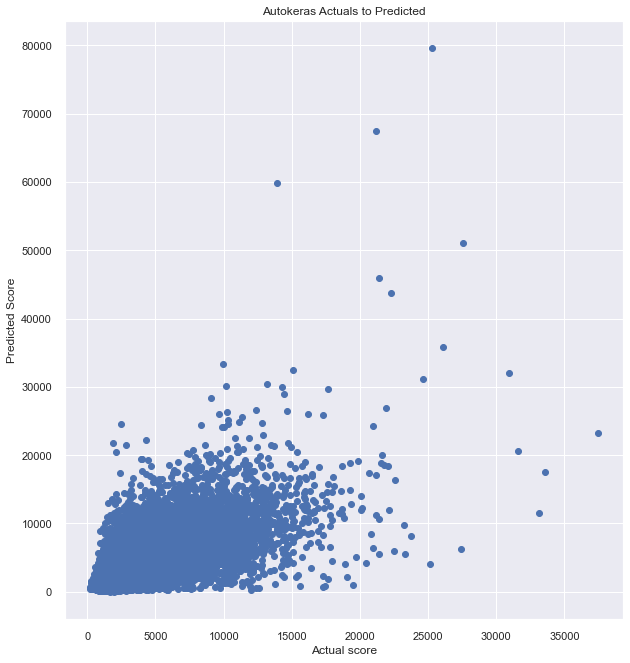

In [85]:
# We can also try training a automl regression model, here let's try autokeras. 
# This will do hyperparamter tuning on keras models, I'm still limited by my machine as 
# far as how many models I can try, but am interested in how this performs

import tensorflow as tf

import autokeras as ak

import timeit


ak_reg = ak.StructuredDataRegressor(project_name="allstate_week3", 
                                    max_trials=50, 
                                    tuner='greedy',
                                    overwrite=True)

start_time = timeit.default_timer()
# x is the path to the csv file. y is the column name of the column to predict.

ak_reg.fit(X, y, epochs=10)
stop_time = timeit.default_timer()

# Evaluate the accuracy of the found model.
accuracy = ak_reg.evaluate(X_test, y_test)[1]
print("Mean squared error: {accuracy}".format(accuracy=round(accuracy, 2)))
print(
    "Total time: {time} seconds.".format(time=round(stop_time - start_time, 2))
)

y_pred_ak = ak_reg.predict(X_test)

y_pred_ak = [x[0] for x in y_pred_ak.tolist()]

fig = plt.figure(figsize=(10,11))
ax1 = plt.subplot(111)

rmse1 = np.sqrt(metrics.mean_squared_error(y_pred_ak, y_test))
print ("Root Mean Squared Error: %s" % rmse1)

ax1.scatter(y_pred_ak, y_test)
ax1.set_xlabel("Actual score")
ax1.set_ylabel("Predicted Score")
ax1.title.set_text("Autokeras Actuals to Predicted")

# Pearson correlation for the predicted values
print("Predicted and test have a correlation of: {:.2f}".format(np.corrcoef(y_pred_ak, y_test)[0][1]))


Root Mean Squared Error: 1917.9295261773693
Predicted and test have a correlation of: 0.75


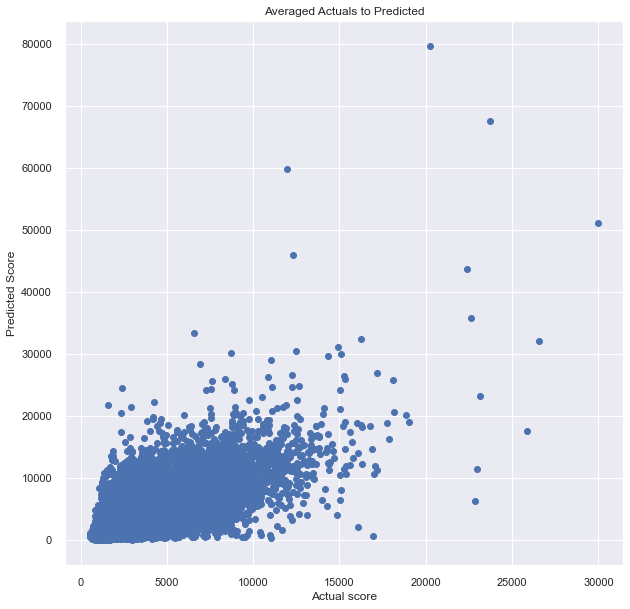

In [86]:
# For a last test step, let's average the two trained predications and see if that improves the results

y_pred_avg = (y_pred_cat + y_pred_ak + predictions) / 3


fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(111)

rmse1 = np.sqrt(metrics.mean_squared_error(y_pred_avg, y_test))

print ("Root Mean Squared Error: %s" % rmse1)

ax1.scatter(y_pred_avg, y_test)
ax1.set_xlabel("Actual score")
ax1.set_ylabel("Predicted Score")
ax1.title.set_text("Averaged Actuals to Predicted")

# Pearson correlation for the predicted values
print("Predicted and test have a correlation of: {:.2f}".format(np.corrcoef(y_pred_avg, y_test)[0][1]))

In [88]:
# And finally, let's pull in the test kaggle data and produce predictions with our models, leaving out the linear model
# because that increased the error


testPredictDfEncoded = pd.get_dummies(allstateTestDf[topFeatures], columns=top20binary, drop_first=True)
testPredictDfEncoded[list(topCats)] = testPredictDfEncoded[list(topCats)].astype('category')
testPredictDfEncoded[list(topCats)] = testPredictDfEncoded[list(topCats)].apply(lambda x: x.cat.codes)

rfr_predictions = rfr_trans.predict(testPredictDfEncoded)
cat_predictions = crgr_trans.predict(allstateTestDf[topFeatures])
ak_predictions = ak_reg.predict(allstateTestDf[topFeatures])
net_predictions = pipeline.predict(testPredictDfEncoded)

ak_predictions = [x[0] for x in ak_predictions.tolist()]

df = pd.DataFrame((rfr_predictions + cat_predictions + ak_predictions) / 3,  columns=["loss"])
df["id"] = allstateTestDf['id']

# Catboost only, this is still the best
df_onlycatboost = pd.DataFrame(cat_predictions,  columns=["loss"])
df_onlycatboost["id"] = allstateTestDf['id']

#Tuned Elasticnet, not the best but better then linear regression alone
df_onlyelasticnet = pd.DataFrame(net_predictions,  columns=["loss"])
df_onlyelasticnet["id"] = allstateTestDf['id']


df.to_csv("allstate-claims-severity/predictions.csv", index=False)

df_onlycatboost.to_csv("allstate-claims-severity/predictions_catboost.csv", index=False)

df_onlyelasticnet.to_csv("allstate-claims-severity/predictions_elastic.csv", index=False)




3924/3924 [==============================] - 9s 2ms/step


## Summary <a class="anchor" id="Summary"></a>

In the training set the best performing regressor was created by using the Catboost regressor model, with an average error of 1907. I added an attempt at using autokeras to train a keras regression model along with the random forest prediction model. Averaging the three predictors gave me an average error of 1936, which was a little worse, but I tried both the catboost, elasticnet and the averaged results, along with ElasticNet as a control.

Prediction results from kaggle: 
#### ElasticNet model: 1321.69 on kaggle
#### Averaged model: 1156.5 on kaggle
#### Catboost model: 1138.33 on kaggle

The optimal score was from Catboost by itself with a public score of 1138. 

What the models tell me are that using the selection of features I chose from the top features in binary variables, multi-class variables and continuous variables, and utilizing some amount of hyper parameter tuning, was able to create predictions that explained 75% of the variability for loss in the testing data I created for validation. I also found that it is hard to increase the predictive value beyond that baseline, and that tuning the parameters has diminishing returns.  

The hyperparameter tuning was expensive and took a lot of time on my 13 inch macbook, so with better hardware, I'm sure that could be vastly improved. Not the winning kaggle prediction by any means, but I think not too bad for my first attempt. Also, it seems like after some tuning attempts the results ended up degrading a little, so I've discovered that hyperparemter tuning is hard on it's own, really. 
Here are my results:


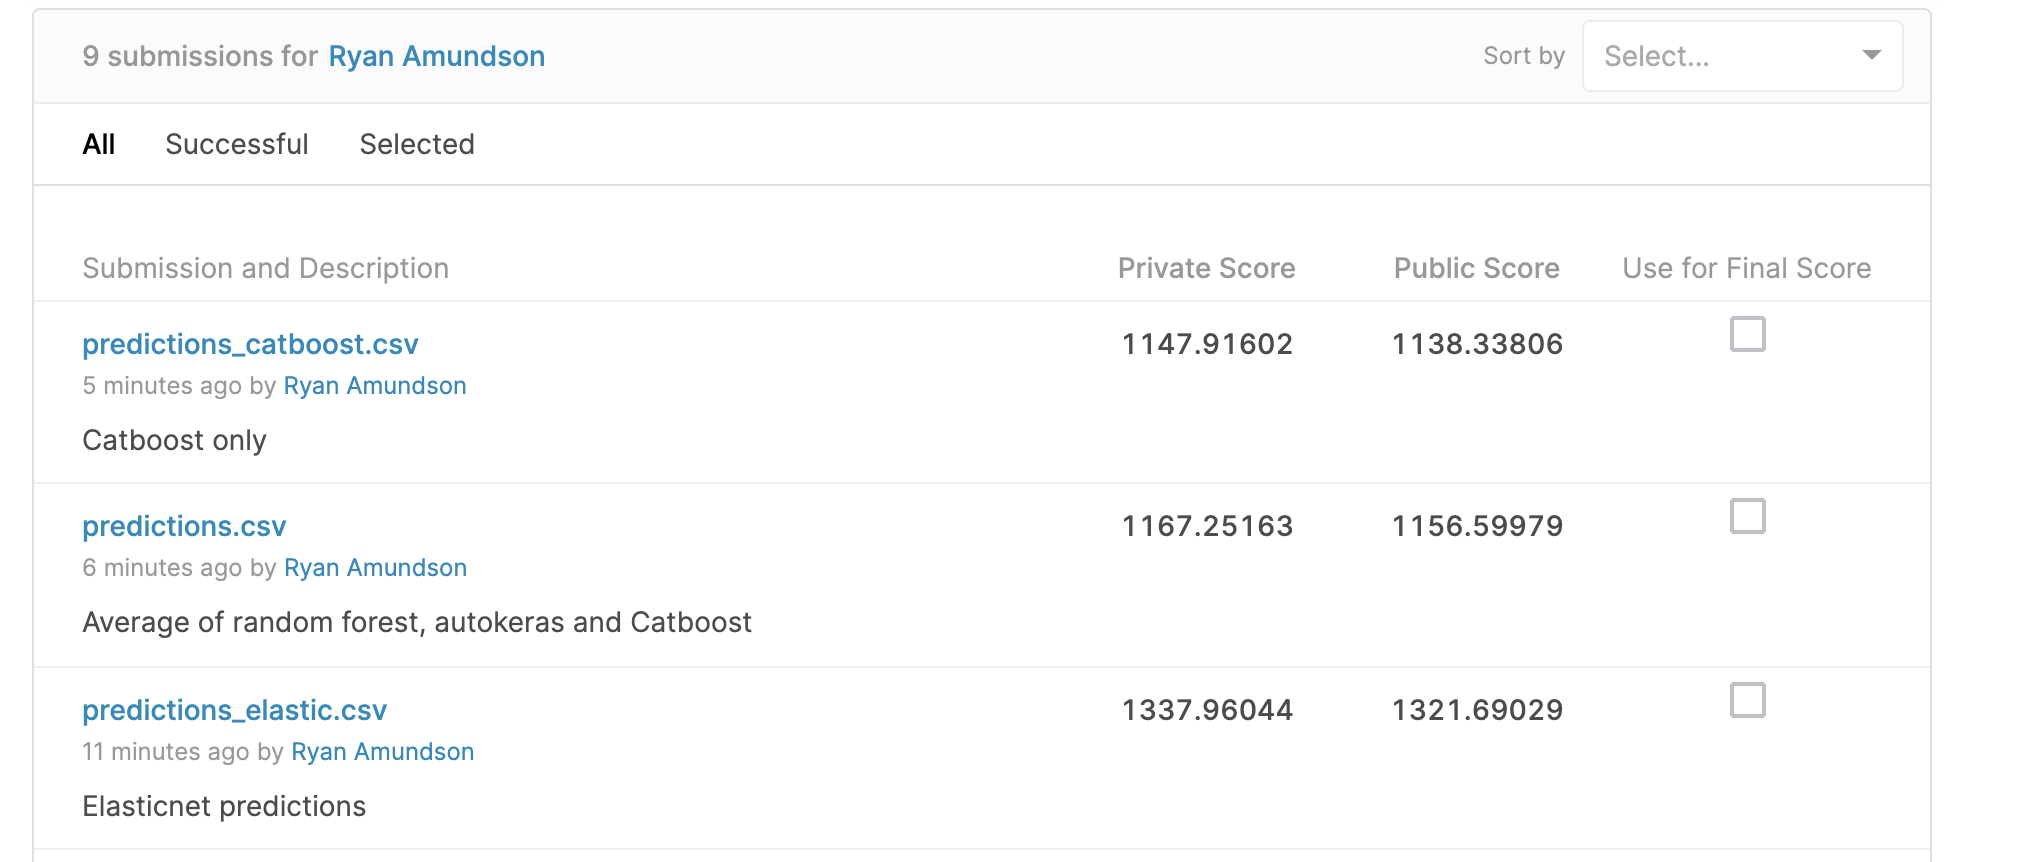